# Test ETL Process with Rick & Morty Character Data

Install the Libraries

In [19]:
pip install pandas requests matplotlib pyodbc scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached scikit_learn-1.3.0-cp310-cp310-win_amd64.whl (9.2 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scipy-1.11.2-cp310-cp310-win_amd64.whl (44.0 MB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)


Import the Libraries

In [2]:
import pandas as pd
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from IPython.display import display
import pyodbc as odbc

Query the data from the API with pagination

In [ ]:
data = rq.get("https://rickandmortyapi.com/api/character")
response = data.json()
characters = response["results"]
resinfo = response["info"]
while resinfo["next"]:
        new_data = rq.get(resinfo["next"])
        new_res = new_data.json()
        characters.extend(new_res["results"])
        resinfo = new_res["info"]

        
        

Fotmat the JSON data into python dictionaries

In [ ]:
import json

for character in characters:
    character['origin'] = json.loads(character['origin'])
    character['location'] = json.loads(character['location'])
    character['episodes'] = json.dumps(episodes)

Insert the data into a pandas dataframe

In [ ]:
df = pd.DataFrame(characters)
display(df)

Establish a secure connection with the DB and transfer the Dataframe rows into the DB. Then close cursor and DB connection

In [115]:
server = 'rickandmorty.database.windows.net'
database = 'RickAndMorty'
username = 'CloudSAd59361be'
password = 'HalloInterns123!'
driver= '{ODBC Driver 17 for SQL Server}'

# Define a table name
table_name = 'characters'

cnxn = odbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
# Insert Dataframe into SQL Server:
for index, row in df.iterrows():
    cursor.execute(
        "IF EXISTS (SELECT 1 FROM characters WHERE id = ?) "
        "   UPDATE characters SET name = ?, status = ?, species = ?, type = ?, "
        "   gender = ?, origin_name = ?, origin_url = ?, "
        "   location_name = ?, location_url = ?, image = ?, episode = ?, url = ?, created = ? "
        "   WHERE id = ? "
        "ELSE "
        "   INSERT INTO characters (id, name, status, species, type, gender, origin_name, origin_url, location_name, location_url, image, episode, url, created) "
        "   VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
        int(row['id']), str(row['name']), str(row['status']), str(row['species']), str(row['type']), 
        str(row['gender']), str(row['origin']['name']), str(row['origin']['url']), 
        str(row['location']['name']), str(row['location']['url']), str(row['image']), 
        str(row['episode']), str(row['url']), str(row['created']),
        int(row['id']), int(row['id']), str(row['name']), str(row['status']), str(row['species']), 
        str(row['type']), str(row['gender']), str(row['origin']['name']), str(row['origin']['url']), 
        str(row['location']['name']), str(row['location']['url']), str(row['image']), 
        str(row['episode']), str(row['url']), str(row['created'])
    )


cnxn.commit()
cursor.close()
cnxn.close()


Transform the Data for Machine Learning

In [7]:
ml_data = df.drop(["name", "id", "type", "origin", "location", "image", "episode", "url", "created" ], axis=1)
display(ml_data)

,status,species,gender
0,Alive,Human,Male
1,Alive,Human,Male
2,Alive,Human,Female
3,Alive,Human,Female
4,Alive,Human,Male
...,...,...,...
821,unknown,Human,Male
822,unknown,Human,Female
823,unknown,Human,Female
824,unknown,Human,Male


Exclude the gender and species columns from the table

In [8]:
dataset = ml_data.drop(["species", "gender"], axis=1)
display(dataset)

,status
0,Alive
1,Alive
2,Alive
3,Alive
4,Alive
...,...
821,unknown
822,unknown
823,unknown
824,unknown


One hot encode both species and gender columns

In [15]:
species = pd.get_dummies(ml_data.species).iloc[:,1:]
gender = pd.get_dummies(ml_data.gender).iloc[:,1:]
numeric_columns = pd.concat([species, gender], axis=1)
display(numeric_columns)

,Animal,Cronenberg,Disease,Human,Humanoid,Mythological Creature,Poopybutthole,Robot,unknown,Genderless,Male,unknown
0,False,False,False,True,False,False,False,False,False,False,True,False
1,False,False,False,True,False,False,False,False,False,False,True,False
2,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
821,False,False,False,True,False,False,False,False,False,False,True,False
822,False,False,False,True,False,False,False,False,False,False,False,False
823,False,False,False,True,False,False,False,False,False,False,False,False
824,False,False,False,True,False,False,False,False,False,False,True,False


Integrate the columns into the main Data Frame

In [17]:
dataset = pd.concat([dataset, species, gender], axis=1)
display(dataset)

,status,Animal,Cronenberg,Disease,Human,Humanoid,Mythological Creature,Poopybutthole,Robot,unknown,...,Disease,Human,Humanoid,Mythological Creature,Poopybutthole,Robot,unknown,Genderless,Male,unknown
0,Alive,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,Alive,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,Alive,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,Alive,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,Alive,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,unknown,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
822,unknown,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
823,unknown,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
824,unknown,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


Separate the column that should be outputed by the model (status)

In [18]:
X = dataset.drop(['status'], axis=1)
y = dataset['status']

Separeta the data into 80% for training and 20% for testing

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Train the Forest Tree Model with the mock data

In [21]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=200, random_state=0)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

Generate a report with the accuracy of the model

In [22]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test,predictions ))
print(accuracy_score(y_test, predictions ))

              precision    recall  f1-score   support

       Alive       0.53      0.98      0.69        84
        Dead       0.88      0.12      0.21        60
     unknown       0.00      0.00      0.00        22

    accuracy                           0.54       166
   macro avg       0.47      0.36      0.30       166
weighted avg       0.58      0.54      0.42       166

0.536144578313253


Plot the most imoortant features that drive the model's results

<Axes: >

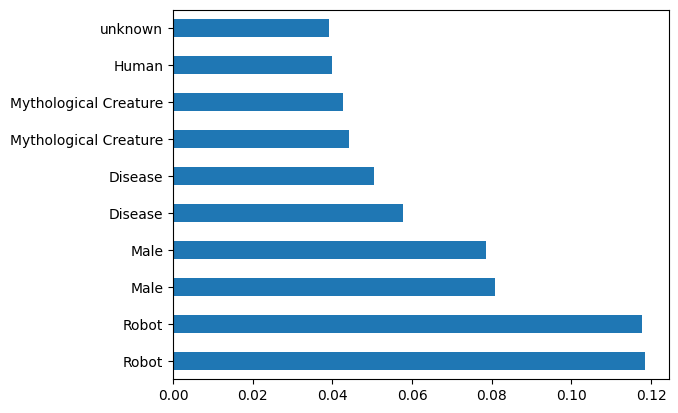

In [23]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

Save the model

In [1]:
import os
import joblib

model_folder = "./model"
model_filename = os.path.join(model_folder, "rickandmorty_model.pkl")
joblib.dump(classifier, model_filename)

NameError: name 'classifier' is not defined